In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb

pd.set_option('display.max_columns', 100)

In [2]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 500 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 1 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = True

import os

In [52]:
lukup = {'defaultCredit':'default.payment.next.month', 'bank':'y'}
name = 'bank'
label = lukup[name]
fold = 2
train_df = pd.read_csv('/home/vineeth/Documents/GitWorkSpace/PytorchRecipes/TabularDataModels/Dataset/{}/fold{}/train/data.csv'.format(name, fold))
valid_df = pd.read_csv('/home/vineeth/Documents/GitWorkSpace/PytorchRecipes/TabularDataModels/Dataset/{}/fold{}/valid/data.csv'.format(name, fold))
test_df = pd.read_csv('/home/vineeth/Documents/GitWorkSpace/PytorchRecipes/TabularDataModels/Dataset/{}/fold{}/test/data.csv'.format(name, fold))
train_label, valid_label, test_label = train_df[label], valid_df[label], test_df[label]
train_df, valid_df, test_df = train_df.drop(label, axis=1), valid_df.drop(label, axis=1), test_df.drop(label, axis=1)
numerical_feat = top_f
# numerical_feat = pd.read_csv('/home/vineeth/Documents/GitWorkSpace/PytorchRecipes/TabularDataModels/Dataset/{}/numerical_clms.csv'.format(name)).columns
train_df = train_df[numerical_feat]
valid_df = valid_df[numerical_feat]
test_df = test_df[numerical_feat]
predictors = list(train_df.columns)
train_df.head()

,nr.employed,emp.var.rate,duration,poutcome,pdays
0,-0.940281,-1.197935,-0.001099,1,0.195414
1,0.845170,0.839061,0.457871,0,0.195414
2,0.331680,0.648092,-0.541064,0,0.195414
3,0.845170,0.839061,-0.209371,0,0.195414
4,-0.940281,-1.197935,-0.240227,0,0.195414


In [53]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df.values, train_label.values.flatten(), feature_names=predictors)
dvalid = xgb.DMatrix(valid_df.values, valid_label.values.flatten(), feature_names=predictors)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = ['auc','aucpr']
params['random_state'] = RANDOM_STATE

In [54]:

model = xgb.train(params, 
                dtrain, 
                
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.75842	train-aucpr:0.40036	valid-auc:0.75947	valid-aucpr:0.38733


/home/vineeth/anaconda3/envs/pytorch_10_23/lib/python3.11/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/home/vineeth/anaconda3/envs/pytorch_10_23/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:23:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.93005	train-aucpr:0.62084	valid-auc:0.92509	valid-aucpr:0.57626
[100]	train-auc:0.93379	train-aucpr:0.63206	valid-auc:0.92900	valid-aucpr:0.58268
[150]	train-auc:0.93556	train-aucpr:0.63667	valid-auc:0.93096	valid-aucpr:0.58838
[200]	train-auc:0.93670	train-aucpr:0.64133	valid-auc:0.93208	valid-aucpr:0.59320
[250]	train-auc:0.93717	train-aucpr:0.64417	valid-auc:0.93275	valid-aucpr:0.59582
[300]	train-auc:0.93763	train-aucpr:0.64624	valid-auc:0.93358	valid-aucpr:0.60290
[350]	train-auc:0.93796	train-aucpr:0.64830	valid-auc:0.93384	valid-aucpr:0.60584
[400]	train-auc:0.93819	train-aucpr:0.64968	valid-auc:0.93399	valid-aucpr:0.60862
[450]	train-auc:0.93843	train-aucpr:0.65173	valid-auc:0.93419	valid-aucpr:0.61049
[500]	train-auc:0.93863	train-aucpr:0.65310	valid-auc:0.93428	valid-aucpr:0.61183
[550]	train-auc:0.93878	train-aucpr:0.65451	valid-auc:0.93429	valid-aucpr:0.61275
[600]	train-auc:0.93899	train-aucpr:0.65573	valid-auc:0.93432	valid-aucpr:0.61261
[650]	train-auc:0

In [55]:
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score, roc_auc_score
dtest = xgb.DMatrix(test_df.values, feature_names=predictors)
y_pred = model.predict(dtest)
print(classification_report(test_label.values.flatten(), np.rint(y_pred)))

print("ROC-AUC:{}".format(roc_auc_score(test_label.values.flatten(), y_pred)))
print("PrecisionRecall-AUC:{}".format(average_precision_score(test_label.values.flatten(), y_pred)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7294
           1       0.66      0.52      0.58       944

    accuracy                           0.91      8238
   macro avg       0.80      0.74      0.77      8238
weighted avg       0.91      0.91      0.91      8238

ROC-AUC:0.9351836225967012
PrecisionRecall-AUC:0.6433759478873144


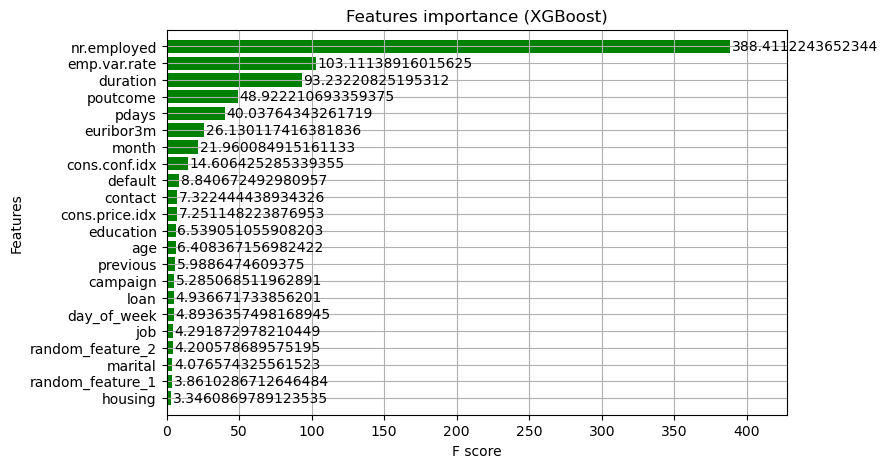

In [50]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green", importance_type='gain') 
plt.show()

In [49]:
# Get feature importances
importances = model.get_score(importance_type='gain')

# Sort features by importance
sorted_features = sorted(importances.items(), key=lambda x: x[1], reverse=True)

# Get top K important features
K = 25  # Change to desired value
top_k_features = sorted_features[:K]

for feature, importance in top_k_features:
    print(f"{feature}: {importance}")

nr.employed: 388.4112243652344
emp.var.rate: 103.11138916015625
duration: 93.23220825195312
poutcome: 48.922210693359375
pdays: 40.03764343261719
euribor3m: 26.130117416381836
month: 21.960084915161133
cons.conf.idx: 14.606425285339355
default: 8.840672492980957
contact: 7.322444438934326
cons.price.idx: 7.251148223876953
education: 6.539051055908203
age: 6.408367156982422
previous: 5.9886474609375
campaign: 5.285068511962891
loan: 4.936671733856201
day_of_week: 4.8936357498168945
job: 4.291872978210449
random_feature_2: 4.200578689575195
marital: 4.076574325561523
random_feature_1: 3.8610286712646484
housing: 3.3460869789123535


In [51]:
top_f = [f for f, v in sorted_features]
top_f = top_f[:5]
top_f

['nr.employed', 'emp.var.rate', 'duration', 'poutcome', 'pdays']